<a href="https://colab.research.google.com/github/shahuzi/tf2.0_learning/blob/master/0_fashion_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.2.0


In [0]:
# import the Fashion MNIST dataset
fashion_mnist = keras.datasets.fashion_mnist
(train_images,train_labels),(test_images,test_labels) = fashion_mnist.load_data()

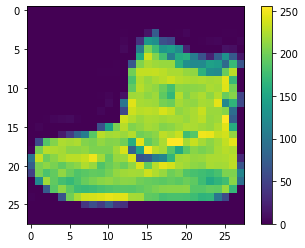

This is a:  Ankle boot


In [0]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.imshow(train_images[0])
plt.colorbar()
plt.show()
print('This is a: ',class_names[train_labels[0]])

In [0]:
# preprocess the value of pixel into 0-1

train_images = train_images / 255.0
test_images = test_images / 255.0

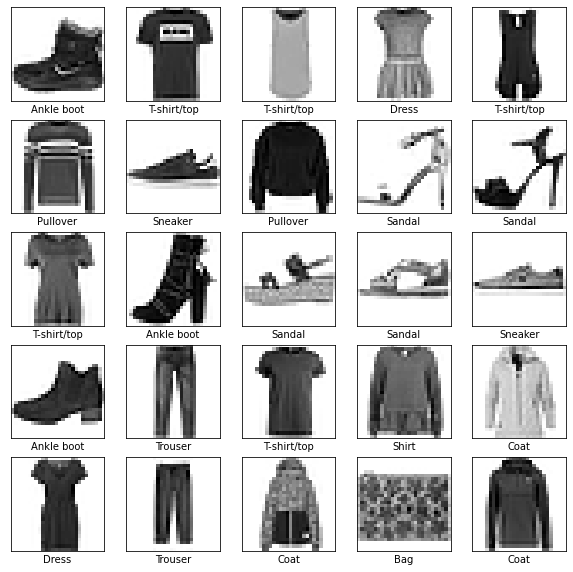

In [0]:
# display the first 25 images after preprocess
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_images[i],cmap=plt.cm.binary)
  plt.xlabel(class_names[train_labels[i]])
plt.show()


In [0]:
# build model, I will use two kind of way here
# 1.use keras.Sequential
# 2.model subclassing

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28,28)),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(10)
])

class MyModel(keras.Model):
  def __init__(self):
    super(MyModel,self).__init__()
    self.conv1 = keras.layers.Conv2D(32,3,activation='relu')
    self.flatten = keras.layers.Flatten()
    self.d1 = keras.layers.Dense(128,activation='relu')
    self.d2 = keras.layers.Dense(10,activation='softmax')

  def call(self,x):
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

model1 = MyModel()


In [0]:
# for way 1
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=10)
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5011 - accuracy: 0.8255
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3787 - accuracy: 0.8645
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3376 - accuracy: 0.8764
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3153 - accuracy: 0.8847
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2940 - accuracy: 0.8922
Epoch 6/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2807 - accuracy: 0.8956
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2675 - accuracy: 0.9000
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2552 - accuracy: 0.9046
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2458 - accuracy: 0.9072
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.238

In [0]:
# for way 2
# shuffle data and split as batch
x_train = train_images[..., tf.newaxis]
x_test = test_images[..., tf.newaxis]
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train,train_labels)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels)).batch(32)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

@tf.function
def train_step(images,labels):
  with tf.GradientTape() as tape:
    predictions = model1(images)
    loss = loss_object(labels,predictions)
  gradients = tape.gradient(loss,model1.trainable_variables)
  optimizer.apply_gradients(zip(gradients,model1.trainable_variables))

  train_loss(loss)
  train_accuracy(labels,predictions)

@tf.function
def test_step(images,labels):
  predictions = model1(images)
  t_loss = loss_object(labels,predictions)

  test_loss(t_loss)
  test_accuracy(labels,predictions)

EPOCHS = 10
for epoch in range(EPOCHS):
  # reset the metrics at the begining of each epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for images,labels in train_ds:
    train_step(images,labels)

  for t_images,t_labels in test_ds:
    test_step(t_images,t_labels)

  template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
  print(template.format(epoch+1,train_loss.result(),train_accuracy.result()*100,test_loss.result(),test_accuracy.result()*100))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 0.3720315098762512, Accuracy: 86.82167053222656, Test Loss: 0.2990933060646057, Test Accuracy: 89.1500015258789
Epoch 2, Loss: 0.2430301010608673, Accuracy: 91.1683349609375, Test Loss: 0.2744525372982025, Test Accuracy: 89.9000015258789
Epoch 3, Loss: 0.1905316412448883, Accuracy: 92.90166473388672, Test Loss: 0.2748495638370514, Test Accuracy: 90.26000213623047
Epoch 4, Loss: 0.14759360253810883, Accuracy: 94.55999755859375, Test Loss: 0.28454020619392395, Test Accuracy: 90.540000915527

In [0]:
# make predictions
# way1 
prob_model = tf.keras.Sequential([model,tf.keras.layers.Softmax()])
preds = prob_model.predict(test_images)
#preds[0]
#print('prediction of preds[0] is %d, label is %d'%(np.argmax(preds[0]),test_labels[0]))
num = preds.shape[0]
cnt = 0
for i in range(num):
  p = np.argmax(preds[i])
  t = test_labels[i]
  if p == t:
    cnt += 1

print('Test accuracy for model: %.5f'%(cnt/num)*100)

Test accuracy for model: 0.88840Test accuracy for model: 0.88840Test accuracy for model: 0.88840Test accuracy for model: 0.88840Test accuracy for model: 0.88840Test accuracy for model: 0.88840Test accuracy for model: 0.88840Test accuracy for model: 0.88840Test accuracy for model: 0.88840Test accuracy for model: 0.88840Test accuracy for model: 0.88840Test accuracy for model: 0.88840Test accuracy for model: 0.88840Test accuracy for model: 0.88840Test accuracy for model: 0.88840Test accuracy for model: 0.88840Test accuracy for model: 0.88840Test accuracy for model: 0.88840Test accuracy for model: 0.88840Test accuracy for model: 0.88840Test accuracy for model: 0.88840Test accuracy for model: 0.88840Test accuracy for model: 0.88840Test accuracy for model: 0.88840Test accuracy for model: 0.88840Test accuracy for model: 0.88840Test accuracy for model: 0.88840Test accuracy for model: 0.88840Test accuracy for model: 0.88840Test accuracy for model: 0.88840Test accuracy for model: 0.88840Test acc

In [0]:
# way2
preds1 = model1(x_test)
#print('prediction of preds1[0] is %d, label is %d'%(np.argmax(preds1[0]),test_labels[0]))
#preds1.shape
num = preds1.shape[0]
cnt = 0
for i in range(num):
  p = np.argmax(preds1[i])
  t = test_labels[i]
  if p == t:
    cnt += 1

print('Test accuracy for model1: %.5f'%(cnt/num)*100)

Test accuracy for model1: 0.90570Test accuracy for model1: 0.90570Test accuracy for model1: 0.90570Test accuracy for model1: 0.90570Test accuracy for model1: 0.90570Test accuracy for model1: 0.90570Test accuracy for model1: 0.90570Test accuracy for model1: 0.90570Test accuracy for model1: 0.90570Test accuracy for model1: 0.90570Test accuracy for model1: 0.90570Test accuracy for model1: 0.90570Test accuracy for model1: 0.90570Test accuracy for model1: 0.90570Test accuracy for model1: 0.90570Test accuracy for model1: 0.90570Test accuracy for model1: 0.90570Test accuracy for model1: 0.90570Test accuracy for model1: 0.90570Test accuracy for model1: 0.90570Test accuracy for model1: 0.90570Test accuracy for model1: 0.90570Test accuracy for model1: 0.90570Test accuracy for model1: 0.90570Test accuracy for model1: 0.90570Test accuracy for model1: 0.90570Test accuracy for model1: 0.90570Test accuracy for model1: 0.90570Test accuracy for model1: 0.90570Test accuracy for model1: 0.90570Test accur

In [0]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  #plt.xticks(range(10))
  plt.xticks(range(10), class_names, rotation=45)
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

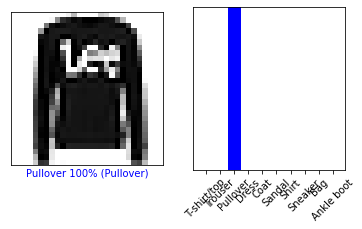

In [0]:
i = 1
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, preds[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, preds[i],  test_labels)
plt.show()

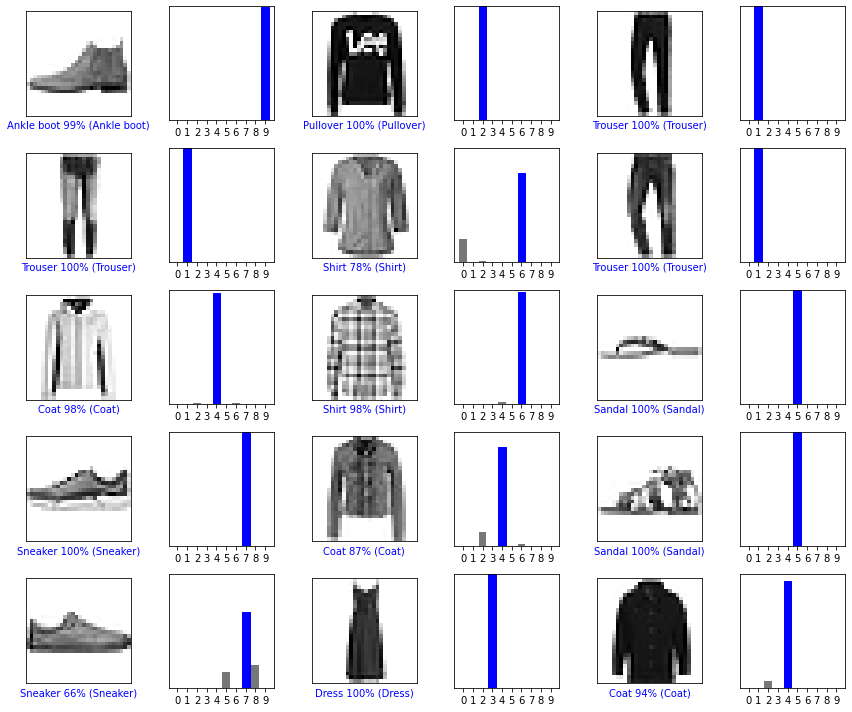

In [0]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, preds[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, preds[i], test_labels)
plt.tight_layout()
plt.show()